# ML Prediction
Ridership predictions are made using different ML algorithms.

## Setup

### Configuration
Set the location that has the input data folder and where all the pickled datasets are stored.

In [1]:
DATA_FOLDER = r"D:\GDrive\GShared\AI Project\AI Transit Prediction\Data"

Set the maximum ridership threshold. Routes with ridership above the maximum ridership threshold will be removed. If value is negative, no observations will be removed.

In [2]:
MAX_RIDERSHIP = -1

Set the proportion of training dataset that should be set aside for testing.

In [3]:
TEST_RATIO = 0.3

Set number of folds to be used for cross-validation.

In [4]:
CV_FOLDS = 5

Set the random seed to be used for generating random numbers.

In [5]:
RANDOM_SEED = 0

Set the folder where model results are to be saved. Warning: This folder should already exist. Files in this folder may be overwritten without warning.

In [6]:
RESULT_FOLDER = r"D:\GDrive\GShared\AI Project\AI Transit Prediction\Results"

Set the folder where fitted models are to be saved. The models at this location can later be accessed by a prediction program.

In [7]:
MODELS_FOLDER = r"D:\GDrive\GShared\AI Project\AI Transit Prediction\Models"

### Loading Libraries

### Loading Libraries

In [8]:
import sys
import os
import time
import pickle
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import ensemble
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

print("Python version:", sys.version)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Scikit-learn version:", sklearn.__version__)

Python version: 3.7.8 | packaged by conda-forge | (default, Jul 23 2020, 03:17:32) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.1
Pandas version: 1.1.0
Matplotlib version: 3.3.0
Scikit-learn version: 0.23.1


Setting reslution of inline images.

In [9]:
matplotlib.rcParams['figure.dpi']= 150

### Estimation Dataset

Loading the estimation dataset.

In [10]:
est_dat = pd.read_pickle(os.path.join(DATA_FOLDER, "route_est_dat.pickle"))

Removing "The Spur" because it is an outlier.

In [11]:
est_dat = est_dat[est_dat["route_short_name"] != "THE SPUR"]

Filtering estimation data based on <code>MAX_RIDERSHIP</code>.

In [12]:
if MAX_RIDERSHIP > 0:
    est_dat = est_dat.loc[est_dat["ridership"] <= MAX_RIDERSHIP]

Seperating features and dependent value.

In [13]:
X = est_dat.drop("ridership", axis=1)
y = est_dat["ridership"]

### Subsetting Features

The estimation dataset has a large number of features.

In [14]:
print("No. of features: ", X.shape[1])

No. of features:  146


We should reduce the number of features to reduce the chances of overfitting. Also, textual features and columns such as <i>agency_id</i> are not valid features. Therefore, in our final models, we consider only a subset of all the available features. These features are:

In [15]:
main_cols = ['PerAMP_route_freq', 'PerMD1_route_freq', 'PerMD2_route_freq', 'PerPMP_route_freq', 'PerNyt_route_freq',
             'n_stops', "high_freq",
             'b02_HH_V0', 'b0204_HH_V0', 'b0408_HH_V0',
             'b02_HH_IG1', 'b02_HH_IG2', 'b02_HH_IG3',  # Not including IG4
             'b0204_HH_IG1', 'b0204_HH_IG2', 'b0204_HH_IG3',  # Not including IG4
             'b0408_HH_IG1', 'b0408_HH_IG2', 'b0408_HH_IG3',  # Not including IG4
             'b02_POP', 'b0204_POP', 'b0408_POP',
             'b02_HH', 'b0204_HH', 'b0408_HH',
             'b02_Emp', 'b0204_Emp', 'b0408_Emp',
             'b02_HH_W1', 'b02_HH_W2', 'b02_HH_W3', # Not including W0
             'b0204_HH_W1', 'b0204_HH_W2', 'b0204_HH_W3',  # Not including W0
             'b0408_HH_W1', 'b0408_HH_W2', 'b0408_HH_W3',  # Not including W0
             'b02_HH_C1', 'b02_HH_C2',  # Not including C0
             'b0204_HH_C1', 'b0204_HH_C2',  # Not including C0
             'b0408_HH_C1', 'b0408_HH_C2']  # Not including C0

In [16]:
X = X[main_cols]

Storing columns used in X dataset because the same columns have to be used when prediction is done later.

In [17]:
with open(os.path.join(MODELS_FOLDER, "Train_Columns.txt"), "w") as ostream:
    print('\n'.join(X.columns.tolist()), file=ostream)

### Data Splitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, random_state=RANDOM_SEED, stratify=pd.qcut(y, [0,.25, .5, .75, 1]))

Selecting indices of records to be included in different cross-validation sets (<code>train_cv</code>).

In [19]:
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_SEED)
train_cv = list(skf.split(X=X_train, y=pd.qcut(y_train, [0,.25, .5, .75, 1], labels=False)))

Table for storing predicted riderhsip.

In [20]:
output_table = pd.DataFrame({"true_ridership": y})
output_table["Train_Test"] = np.nan
output_table.loc[X_train.index, "Train_Test"] = "Train"
output_table.loc[X_test.index, "Train_Test"] = "Test"
output_table["CV_Fold"] = 0
for i in range(CV_FOLDS):
    output_table.loc[X_train.index[train_cv[i][1]], "CV_Fold"] = i+1

In [21]:
output_table

,true_ridership,Train_Test,CV_Fold
route_id,,,
14686,1935.546875,Train,5
14688,4268.187500,Train,4
14707,1537.265625,Test,0
14708,792.234375,Train,3
14689,1226.328125,Test,0
...,...,...,...
4545,114.913043,Train,5
4546,52.173913,Train,1
4516,260.391304,Test,0


In [22]:
result_summary = pd.DataFrame({"train_r2":[], "test_r2":[], "cv_r2":[], "cv_r2_sd":[]})

### Plotting Functions

The <code>accuracy_plot_abs</code> function is used for plotting the predicted value on the Y axis against the true value on the X axis. Points lying closer to the identity line (45&deg; line passing through the origin) imply more accurate prediction. Points lying between the gray dashed lines indicate an absolute error less than 500.<br>
<u>Arguments</u>
<ul>
    <li><code>y</code>: The true values (plotted along X axis)</li>
    <li><code>y_pred</code>: The predicted values (plotted along Y axis)</li>
    <li><code>ax</code>: Matplotlib axes object on which the plot is to be made </li>
    <li><code>highlight</code>: (optional) Vector of strings with same size as <code>y</code> and <code>y_pred</code>. If provided, the points will be colored differently based on the value provided in this vector and a legend will be shown. Warning: Different colors may not be used if highlight has a large number of unique values. </li>
    <li><code>extra_info</code>: (optional) Extra information to be shown at a corner of the plot.</li>
</ul>
<u>Returns</u>
<li>None</li>

In [23]:
def accuracy_plot_abs(y, y_pred, ax, highlight=None, extra_info=None):
    show_legend = True
    if highlight is None:
        show_legend = False
        highlight = pd.Series("ALL", index=y.index)
    df = pd.DataFrame({"y": y, "y_pred":y_pred, "highlight":highlight})
    groups = df.groupby("highlight")
    for name, group in groups:
        ax.scatter(group["y"], group["y_pred"], marker="1", label=name)
    ax.set_xlim([-1000,5000])
    ax.set_ylim([-1000,5000])
    line45 = np.linspace(*ax.get_xlim())
    ax.plot(line45, line45, c="k", lw=1, ls="--")
    ax.plot(line45, line45+500, c="grey", lw=1, ls="--")
    ax.plot(line45, line45-500, c="grey", lw=1, ls="--")
    if extra_info is not None:
        ax.text(-750, 4750, extra_info, ha="left", va="top")
    if show_legend: ax.legend(loc="lower right")
    ax.set_aspect('equal')
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.set_title("Prediction vs Actual Plot")

The <code>accuracy_plot_perc</code> function is used for plotting the percentage of error on the Y axis against the true value on the X axis. Points lying closer to the X axis indicate more accurate prediction. Points with error greater than 450% and less than -450% are all placed at +475% and -475% respectively on the Y axis (so that they do not go beyond the Y axis bounds and become lost). The range between the gray dashed lines indicate an absolute percentage error less than 100%.<br>
<u>Arguments</u>
<ul>
    <li><code>y</code>: The true values (plotted along X axis)</li>
    <li><code>y_pred</code>: The predicted values (plotted along Y axis)</li>
    <li><code>ax</code>: Matplotlib axes object on which the plot is to be made </li>
    <li><code>highlight</code>: (optional) Vector of strings with same size as <code>y</code> and <code>y_pred</code>. If provided, the points will be colored differently based on the value provided in this vector and a legend will be shown. Warning: Different colors may not be used if highlight has a large number of unique values. </li>
    <li><code>extra_info</code>: (optional) Extra information to be shown at a corner of the plot.</li>
</ul>
<u>Returns</u>
<li>None</li>

In [24]:
def accuracy_plot_perc(y, y_pred, ax, highlight=None, extra_info=None):
    show_legend = True
    if highlight is None:
        show_legend = False
        highlight = pd.Series("ALL", index=y.index)
    err_perc = (y_pred - y) / y * 100
    err_perc[err_perc > 450] = 475
    err_perc[err_perc < -450] = -475
    df = pd.DataFrame({"y": y, "err_perc":err_perc, "highlight":highlight})
    ax.hlines(0, xmin=-200, xmax=6000, lw=1, color="black")
    ax.hlines(-100, xmin=-200, xmax=6000, lw=1, color="grey", ls="--")
    ax.hlines(100, xmin=-200, xmax=6000, lw=1, color="grey", ls="--")
    ax.hlines(-450, xmin=-200, xmax=6000, lw=1, color="red", ls="--")
    ax.hlines(450, xmin=-200, xmax=6000, lw=1, color="red", ls="--")
    groups = df.groupby("highlight")
    for name, group in groups:
        ax.scatter(group["y"], group["err_perc"], marker="1", label=name)
    ax.set_xlim([-100,5000])
    ax.set_ylim([-500,500])
    if extra_info is not None:
        ax.text(4750, 450, extra_info, ha="right", va="top")
    if show_legend: ax.legend(loc="lower right")
    ax.set_xlabel("True Value")
    ax.set_ylabel("% Error")
    ax.set_title("% Error Plot")

The <code>evaluate_gof</code> function is used to compute several goodness-of-fit values and goodness-of-fit plots. Specifically, the goodness-of-fit measures that are computed are:
<ul>
    <li>$R^2$ of training dataset.</li>
    <li>$R^2$ of testing dataset.</li>
    <li>Mean of $R^2$s from cross-validation.</li>
    <li>Standard deviation of $R^2$s from cross-validation.</li>
</ul>
Then goodness-of-fit plots are made using the functions <code>accuracy_plot_perc</code> and <code>accuracy_plot_abs</code>. The goodness-of-fit measures are written inside the plot.
<br>
<u>Arguments</u>
<ul>
    <li><code>X_train</code>: Features of training dataset.</li>
    <li><code>X_test</code>: Features of testing dataset.</li>
    <li><code>y_train</code>: Dependent variable of training dataset. </li>
    <li><code>y_train</code>: Dependent variable of testing dataset. </li>
    <li><code>train_cv</code>: Object that can be used to identify cross-validation splitting strategy by the <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html">sklearn.model_selection.cross_val_score</a> function. In this code, we use a list of tuples. Each tuple gives the splitting strategy of a fold and number of items in the list is equal to the number of folds. The first object of a tuple gives indices of the training set of a fold and the second object of the tuple gives indices of the testing set of the fold.</li>
    <li><code>highlight_var</code>: (optional) Column name that contains the vector that needs to be passed as the <code>highlight</code> argument to the functions <code>accuracy_plot_perc</code> and <code>accuracy_plot_abs</code>. Default is <code>None</code>. In this case, highlighting is done to differentiate the training and testing dataset points.</li>
    <li><code>output_location</code>: (optional) Plot will be written to disk at the output location. </li>
</ul>
<u>Returns</u>
<li>None</li>

In [25]:
def evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, highlight_var=None, output_location=None):
    
    y_train_pred = model.predict(X_train)
    y_train_pred = pd.Series(y_train_pred, index=y_train.index)
    y_test_pred = model.predict(X_test)
    y_test_pred = pd.Series(y_test_pred, index=y_test.index)
    cv_scores = cross_val_score(model, X_train, y_train, scoring="r2", cv=train_cv)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    cv_r2 = np.mean(cv_scores)
    cv_r2_sd = np.sqrt(np.var(cv_scores))
    gof_text = "Train $R^{2}$ = %.4f \nTest $R^{2}$ = %.4f \nCV $R^{2}$ Mean: %.4f\nCV $R^{2}$ Std.Dev: %.4f" \
                % (train_r2, test_r2, cv_r2, cv_r2_sd)
    y = pd.concat([y_train, y_test])
    y_pred = pd.concat([y_train_pred, y_test_pred])
    if highlight_var is None:
        highlight = pd.concat([pd.Series("Train", index=X_train.index), pd.Series("Test", index=X_test.index)])
    else:
        highlight = pd.concat([X_train[highlight_var], X_test[highlight_var]])
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 4])
    accuracy_plot_abs(y, y_pred, ax1, highlight=highlight, extra_info=gof_text)
    accuracy_plot_perc(y, y_pred, ax2, highlight=highlight)
    fig.tight_layout()
    if output_location is not None:
        plt.savefig(output_location, dpi=200)
    return train_r2, test_r2, cv_r2, cv_r2_sd

## ML Model Testing

Setting reslution of inline images.

In [26]:
matplotlib.rcParams['figure.dpi']= 150

### Lasso CV

In [27]:
model_name = "LassoCV"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")
model = make_pipeline(column_selector, preprocessing.StandardScaler(), linear_model.LassoCV(max_iter=50000, tol=1e-4, random_state=RANDOM_SEED))
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.376 seconds.


Evaluating goodness-of-fit.

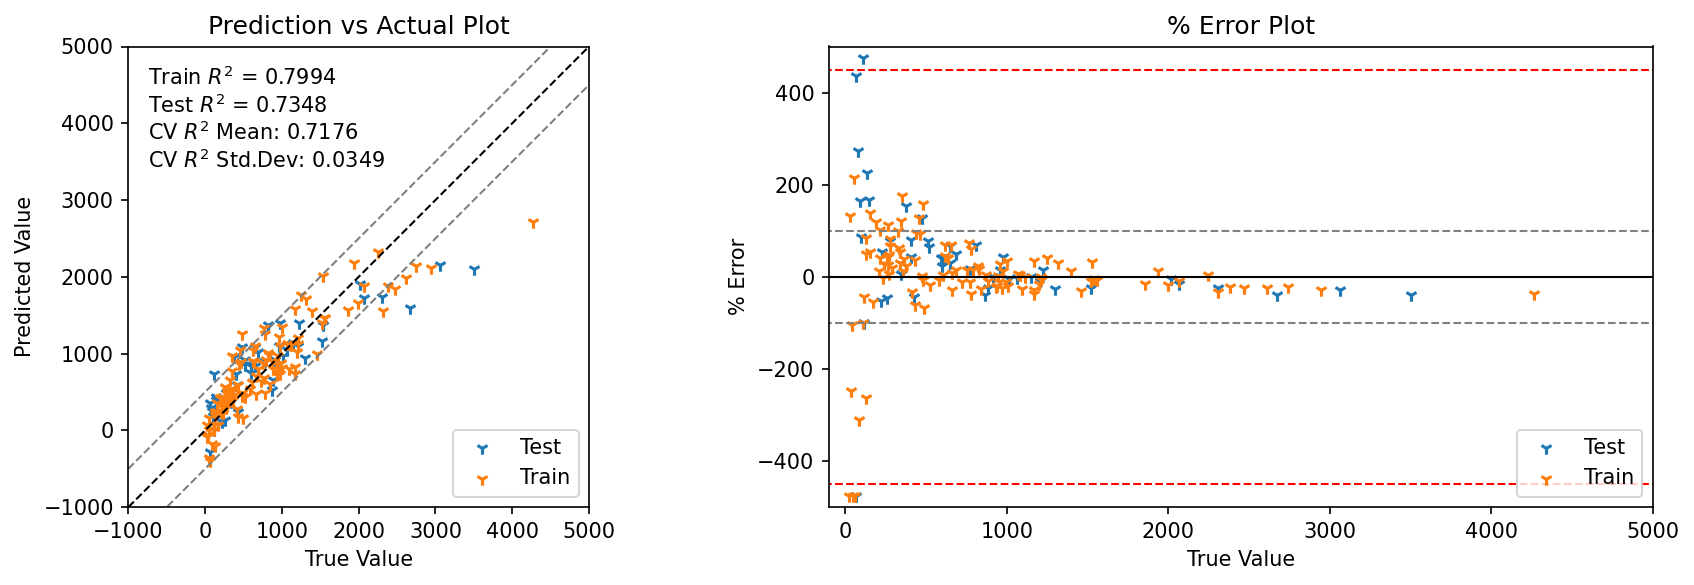

In [28]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Updating prediction table.

In [29]:
output_table.loc[X.index, model_name] = model.predict(X)

Plotting estimated coefficients.

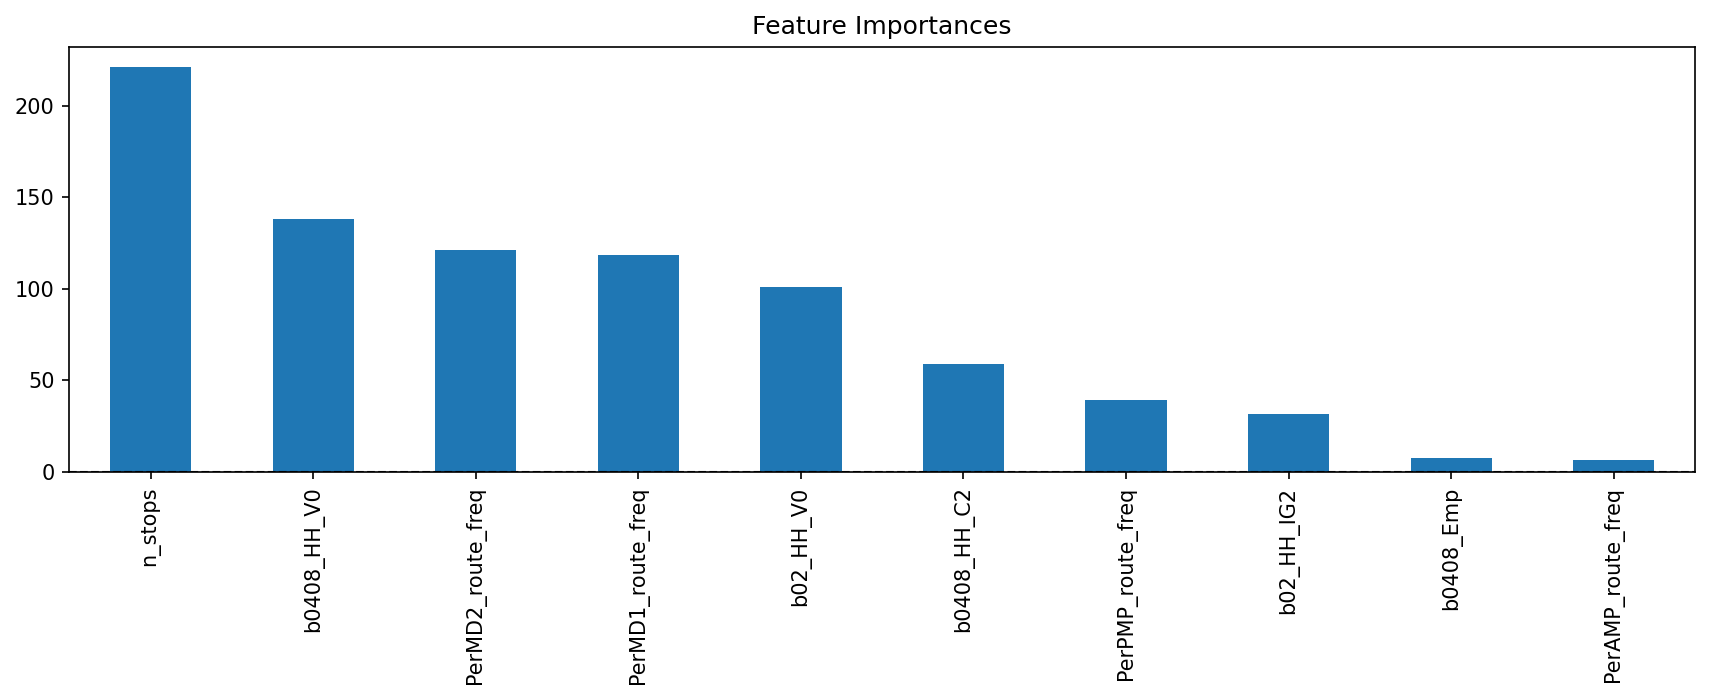

In [30]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Coef.png")
fig= plt.figure(figsize=(11.5,4.76))
coef = pd.Series(model.named_steps["lassocv"].coef_, index=main_cols)
coef = coef[coef!=0].sort_values(ascending=False)
coef.plot(kind = "bar")
plt.axhline(lw=1, color="k", linestyle="--")
plt.title("Feature Importances")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Saving fitted model to file.

In [31]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### RidgeCV

In [32]:
model_name = "RidgeCV"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")
model = make_pipeline(column_selector, preprocessing.StandardScaler(), linear_model.RidgeCV())
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.005 seconds.


Evaluating goodness-of-fit.

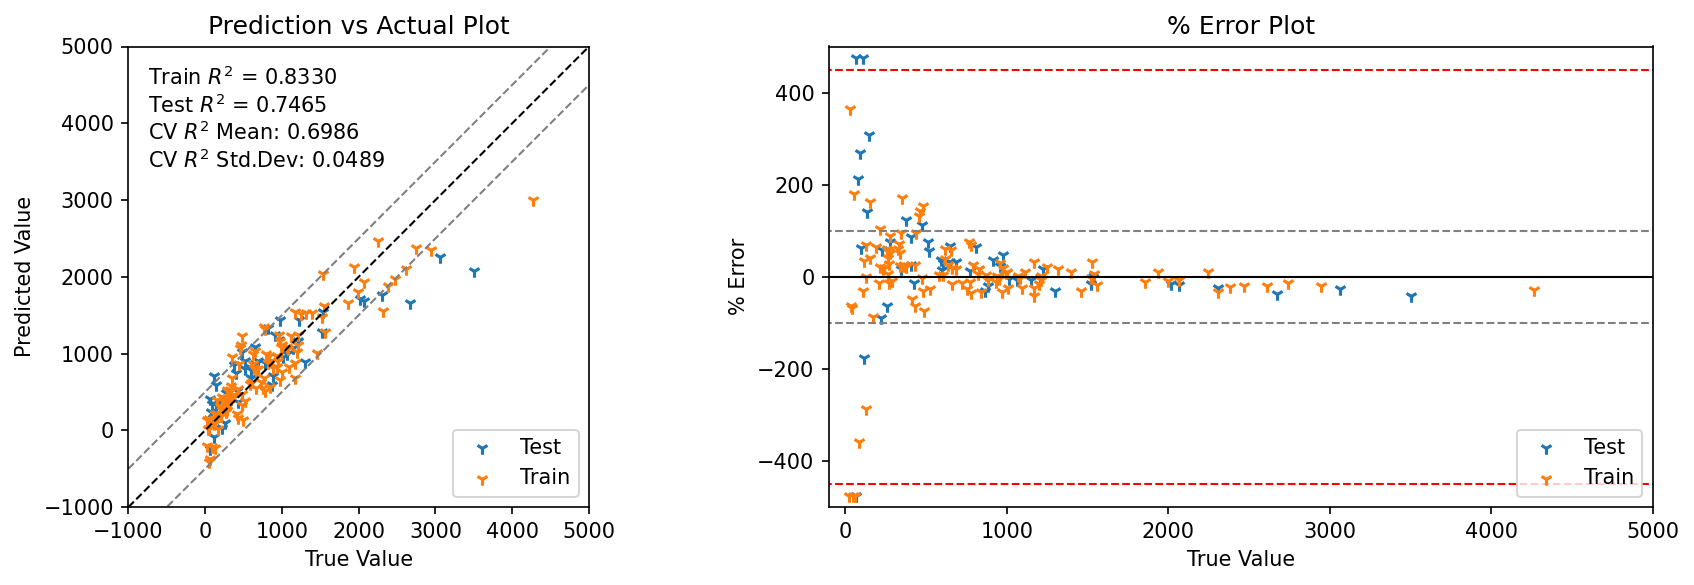

In [33]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Updating prediction table.

In [34]:
output_table.loc[X.index, model_name] = model.predict(X)

Plotting estimated coefficients.

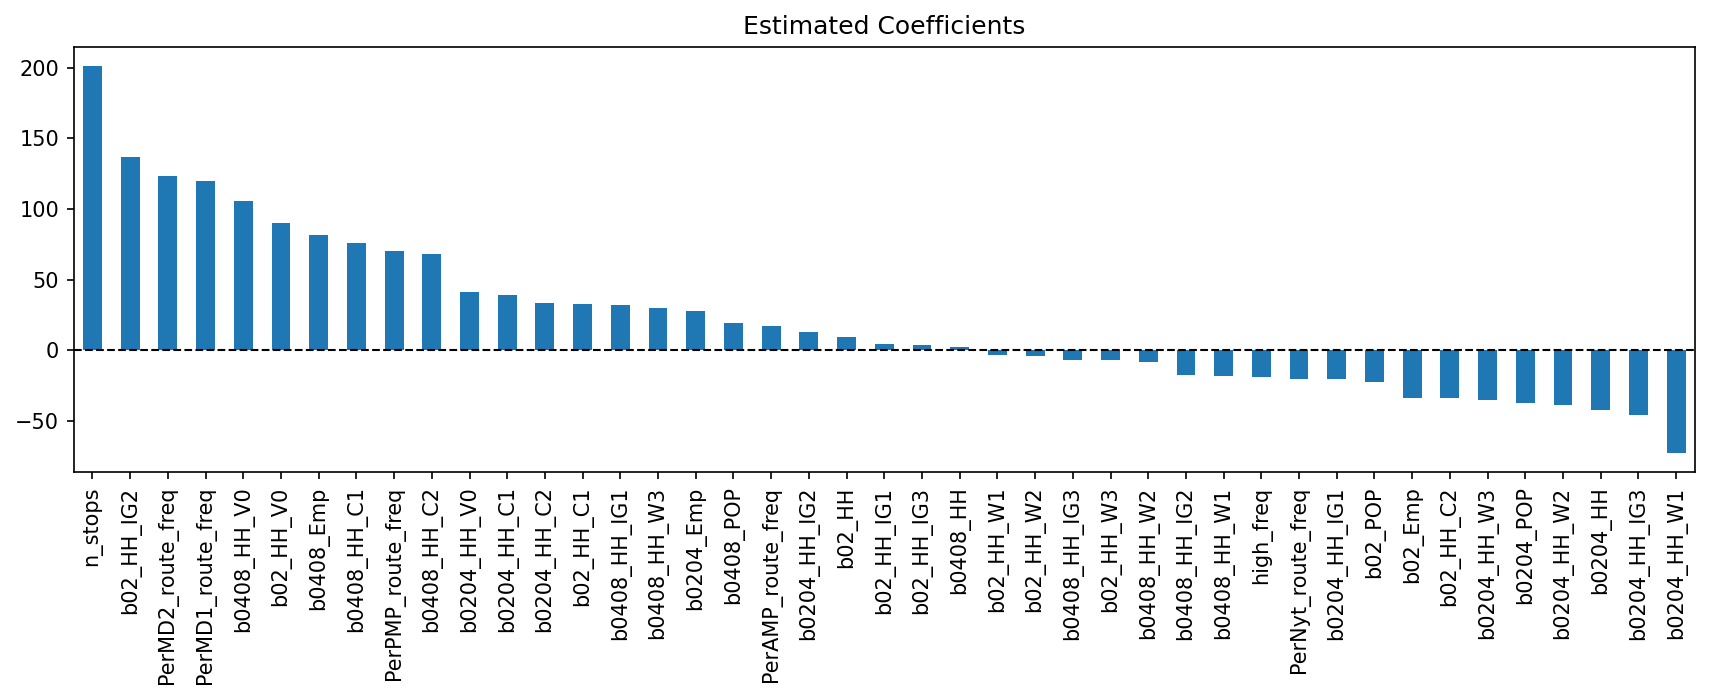

In [35]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Coef.png")
fig= plt.figure(figsize=(11.5,4.76))
coef = pd.Series(model.named_steps["ridgecv"].coef_, index=main_cols)
coef = coef[coef!=0].sort_values(ascending=False)
coef.plot(kind = "bar")
plt.axhline(lw=1, color="k", linestyle="--")
plt.title("Estimated Coefficients")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Saving fitted model to file.

In [36]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### LassoCV with Squares of Features

In [37]:
model_name = "LassoCVSq"
transformer = ColumnTransformer([('select', 'passthrough', main_cols),
                                 ('square', preprocessing.FunctionTransformer(np.square, np.sqrt), main_cols)], remainder="drop")
model = make_pipeline(transformer, preprocessing.StandardScaler(), linear_model.LassoCV(max_iter=50000, tol=1e-4, random_state=RANDOM_SEED)) # Having less than 20000 iterations made it ask to increase max_iter although results didn't change much.
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.8318 seconds.


Evaluating goodness-of-fit.

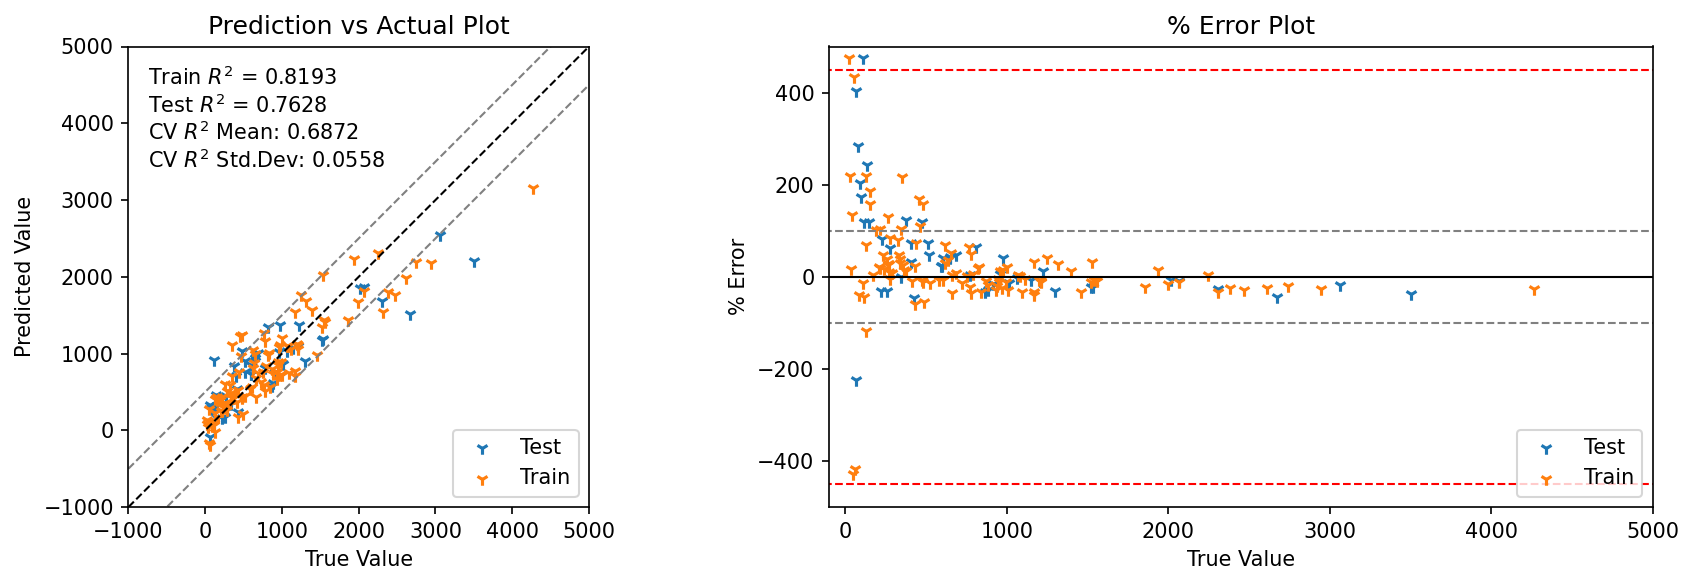

In [38]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Updating prediction table.

In [39]:
output_table.loc[X.index, model_name] = model.predict(X)

Saving fitted model to file.

In [40]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### LassoCV with Squareroots of Features

In [41]:
model_name = "LassoCVSqrt"
transformer = ColumnTransformer([('select', 'passthrough', main_cols),
                                 ('squareroot', preprocessing.FunctionTransformer(np.sqrt, np.square), main_cols)], remainder="drop")
model = make_pipeline(transformer, preprocessing.StandardScaler(), linear_model.LassoCV(max_iter=50000, tol=1e-4, random_state=RANDOM_SEED)) # Having less than 20000 iterations made it ask to increase max_iter although results didn't change much.
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 1.119 seconds.


Evaluating goodness-of-fit.

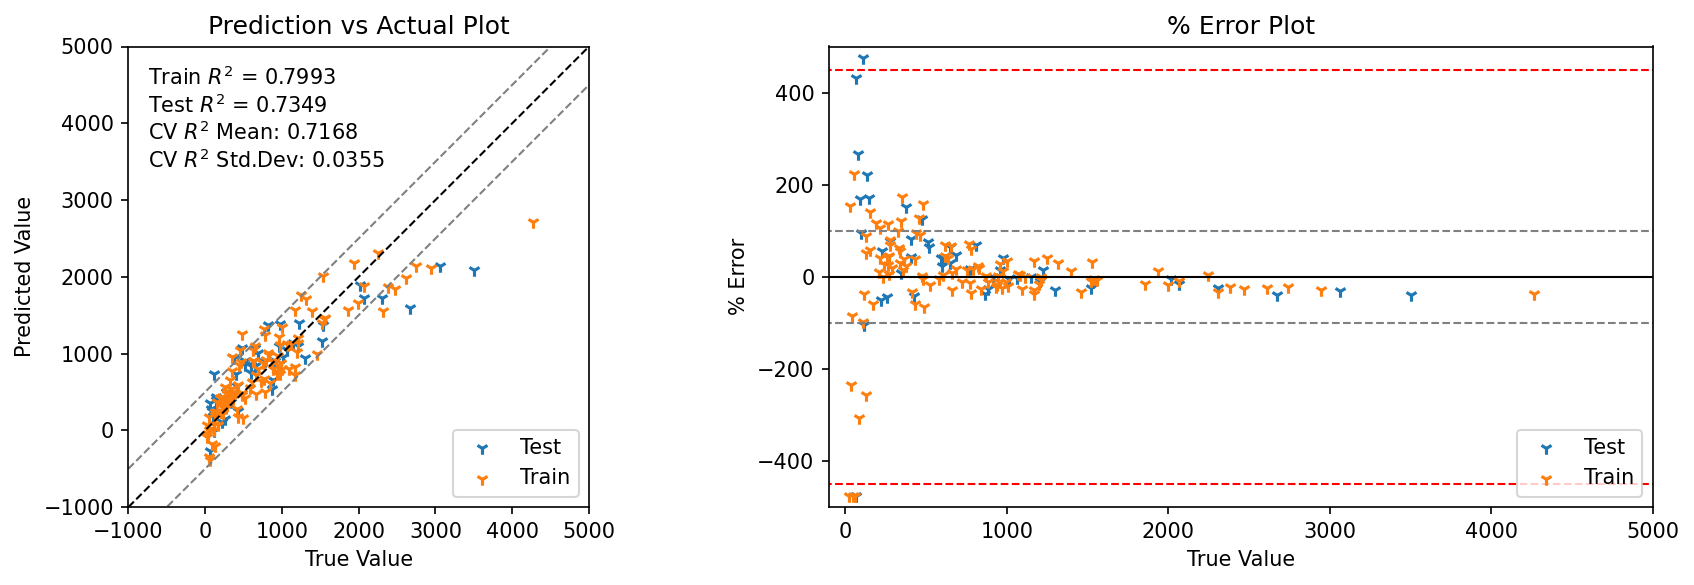

In [42]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Updating prediction table.

In [43]:
output_table.loc[X.index, model_name] = model.predict(X)

Saving fitted model to file.

In [44]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### Decision Tree

In [45]:
model_name = "DecisionTree"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")

Fitting parameters.

In [46]:
hyper_grid = { "decisiontreeregressor__min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
               "decisiontreeregressor__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10] }
model = make_pipeline(column_selector, DecisionTreeRegressor(random_state=RANDOM_SEED))
search_model = GridSearchCV(estimator = model, param_grid = hyper_grid, cv = KFold(n_splits=CV_FOLDS, random_state=RANDOM_SEED, shuffle=True), verbose=1, n_jobs=-2)
search_model.fit(X_train, y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done  50 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-2)]: Done 630 out of 630 | elapsed:    1.7s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['PerAMP_route_freq',
                                                                          'PerMD1_route_freq',
                                                                          'PerMD2_route_freq',
                                                                          'PerPMP_route_freq',
                                                                          'PerNyt_route_freq',
                                                                          'n_stops',
                                                                          'high_freq',
                                                        

Best parameters based on Grid Search.

In [47]:
search_model.best_params_

{'decisiontreeregressor__max_depth': 6,
 'decisiontreeregressor__min_samples_split': 14}

Fitting model.

In [48]:
model.set_params(**search_model.best_params_)
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.003 seconds.


Evaluating goodness-of-fit.

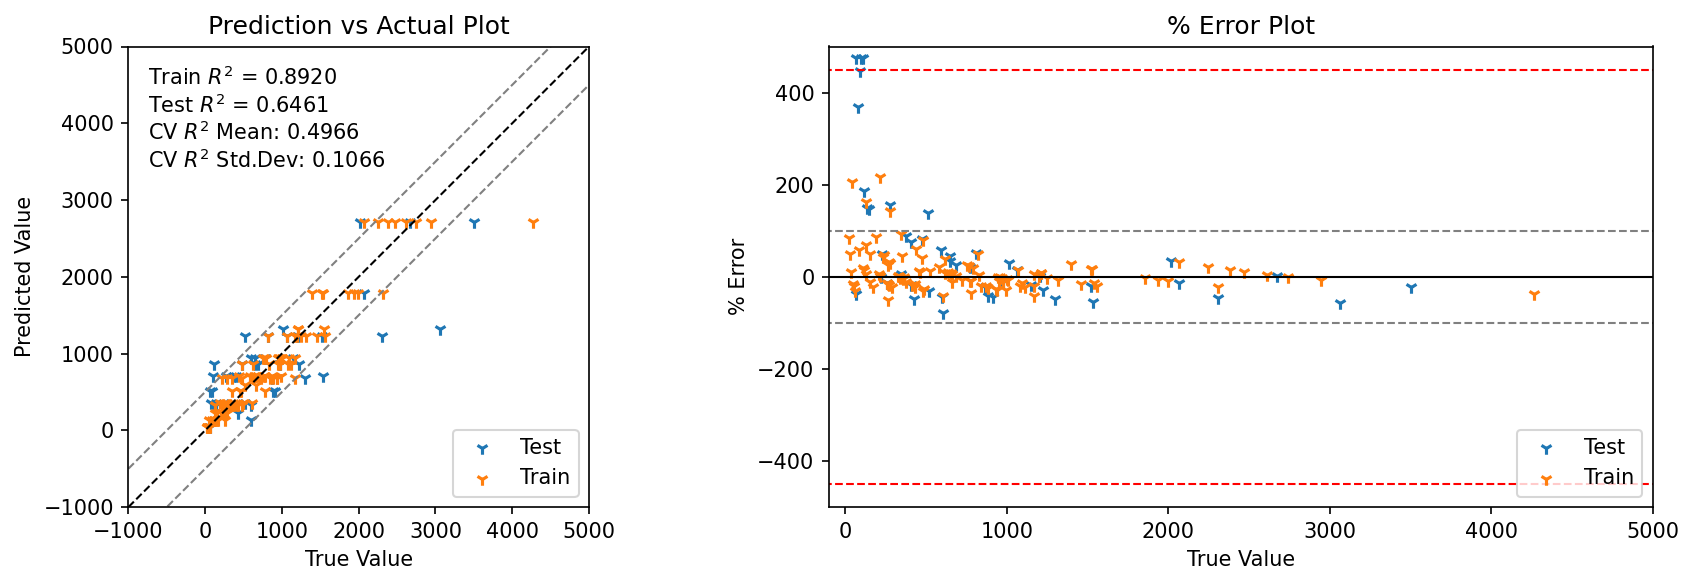

In [49]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Showing feature importances.

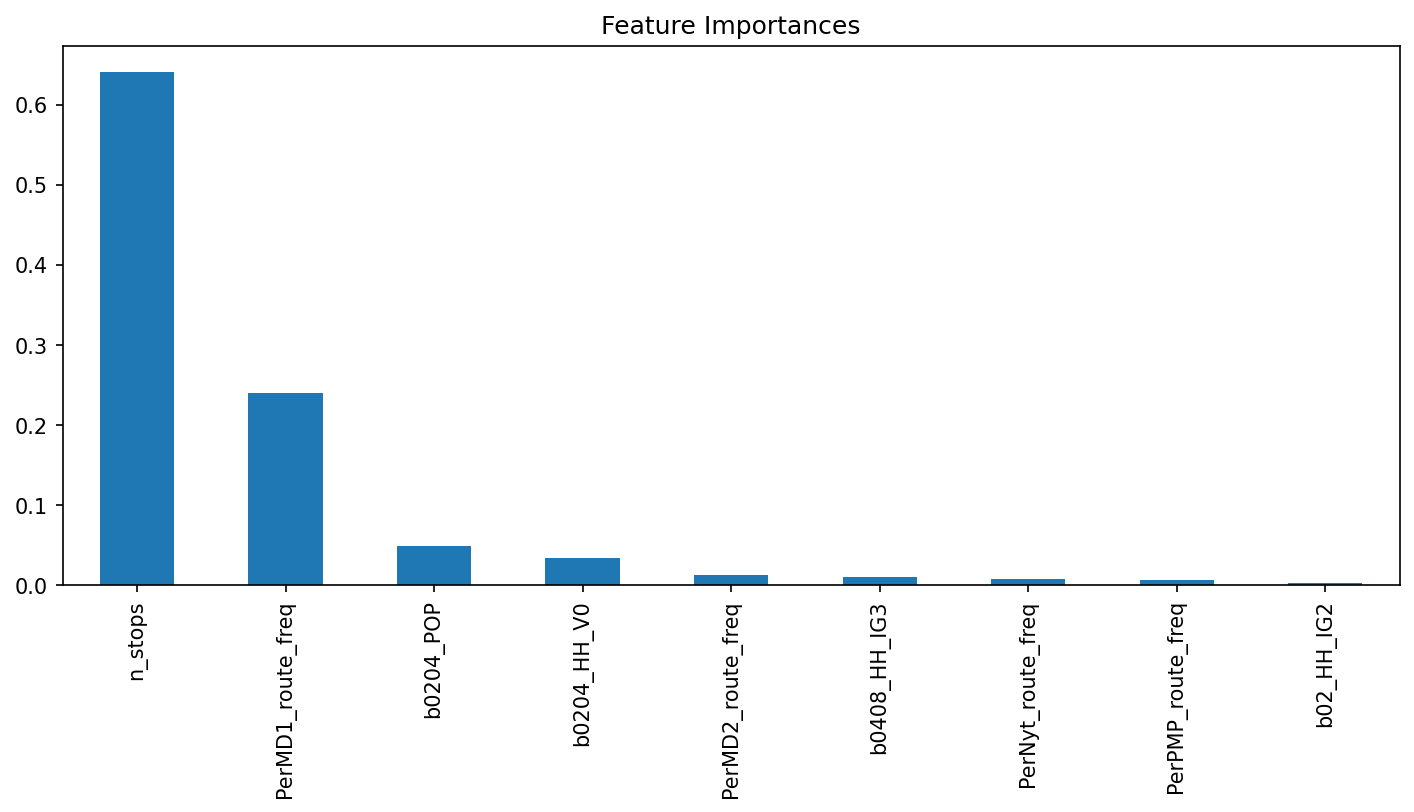

In [50]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Imp.png")
feat_imps = pd.DataFrame({"importance": model["decisiontreeregressor"].feature_importances_}, index=main_cols)
feat_imps[feat_imps['importance']>0].sort_values("importance", ascending=False).plot(kind = "bar", legend=None, figsize=(11.5,4.76))
plt.title("Feature Importances")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Updating prediction table.

In [51]:
output_table.loc[X.index, model_name] = model.predict(X)

Plotting decision tree.

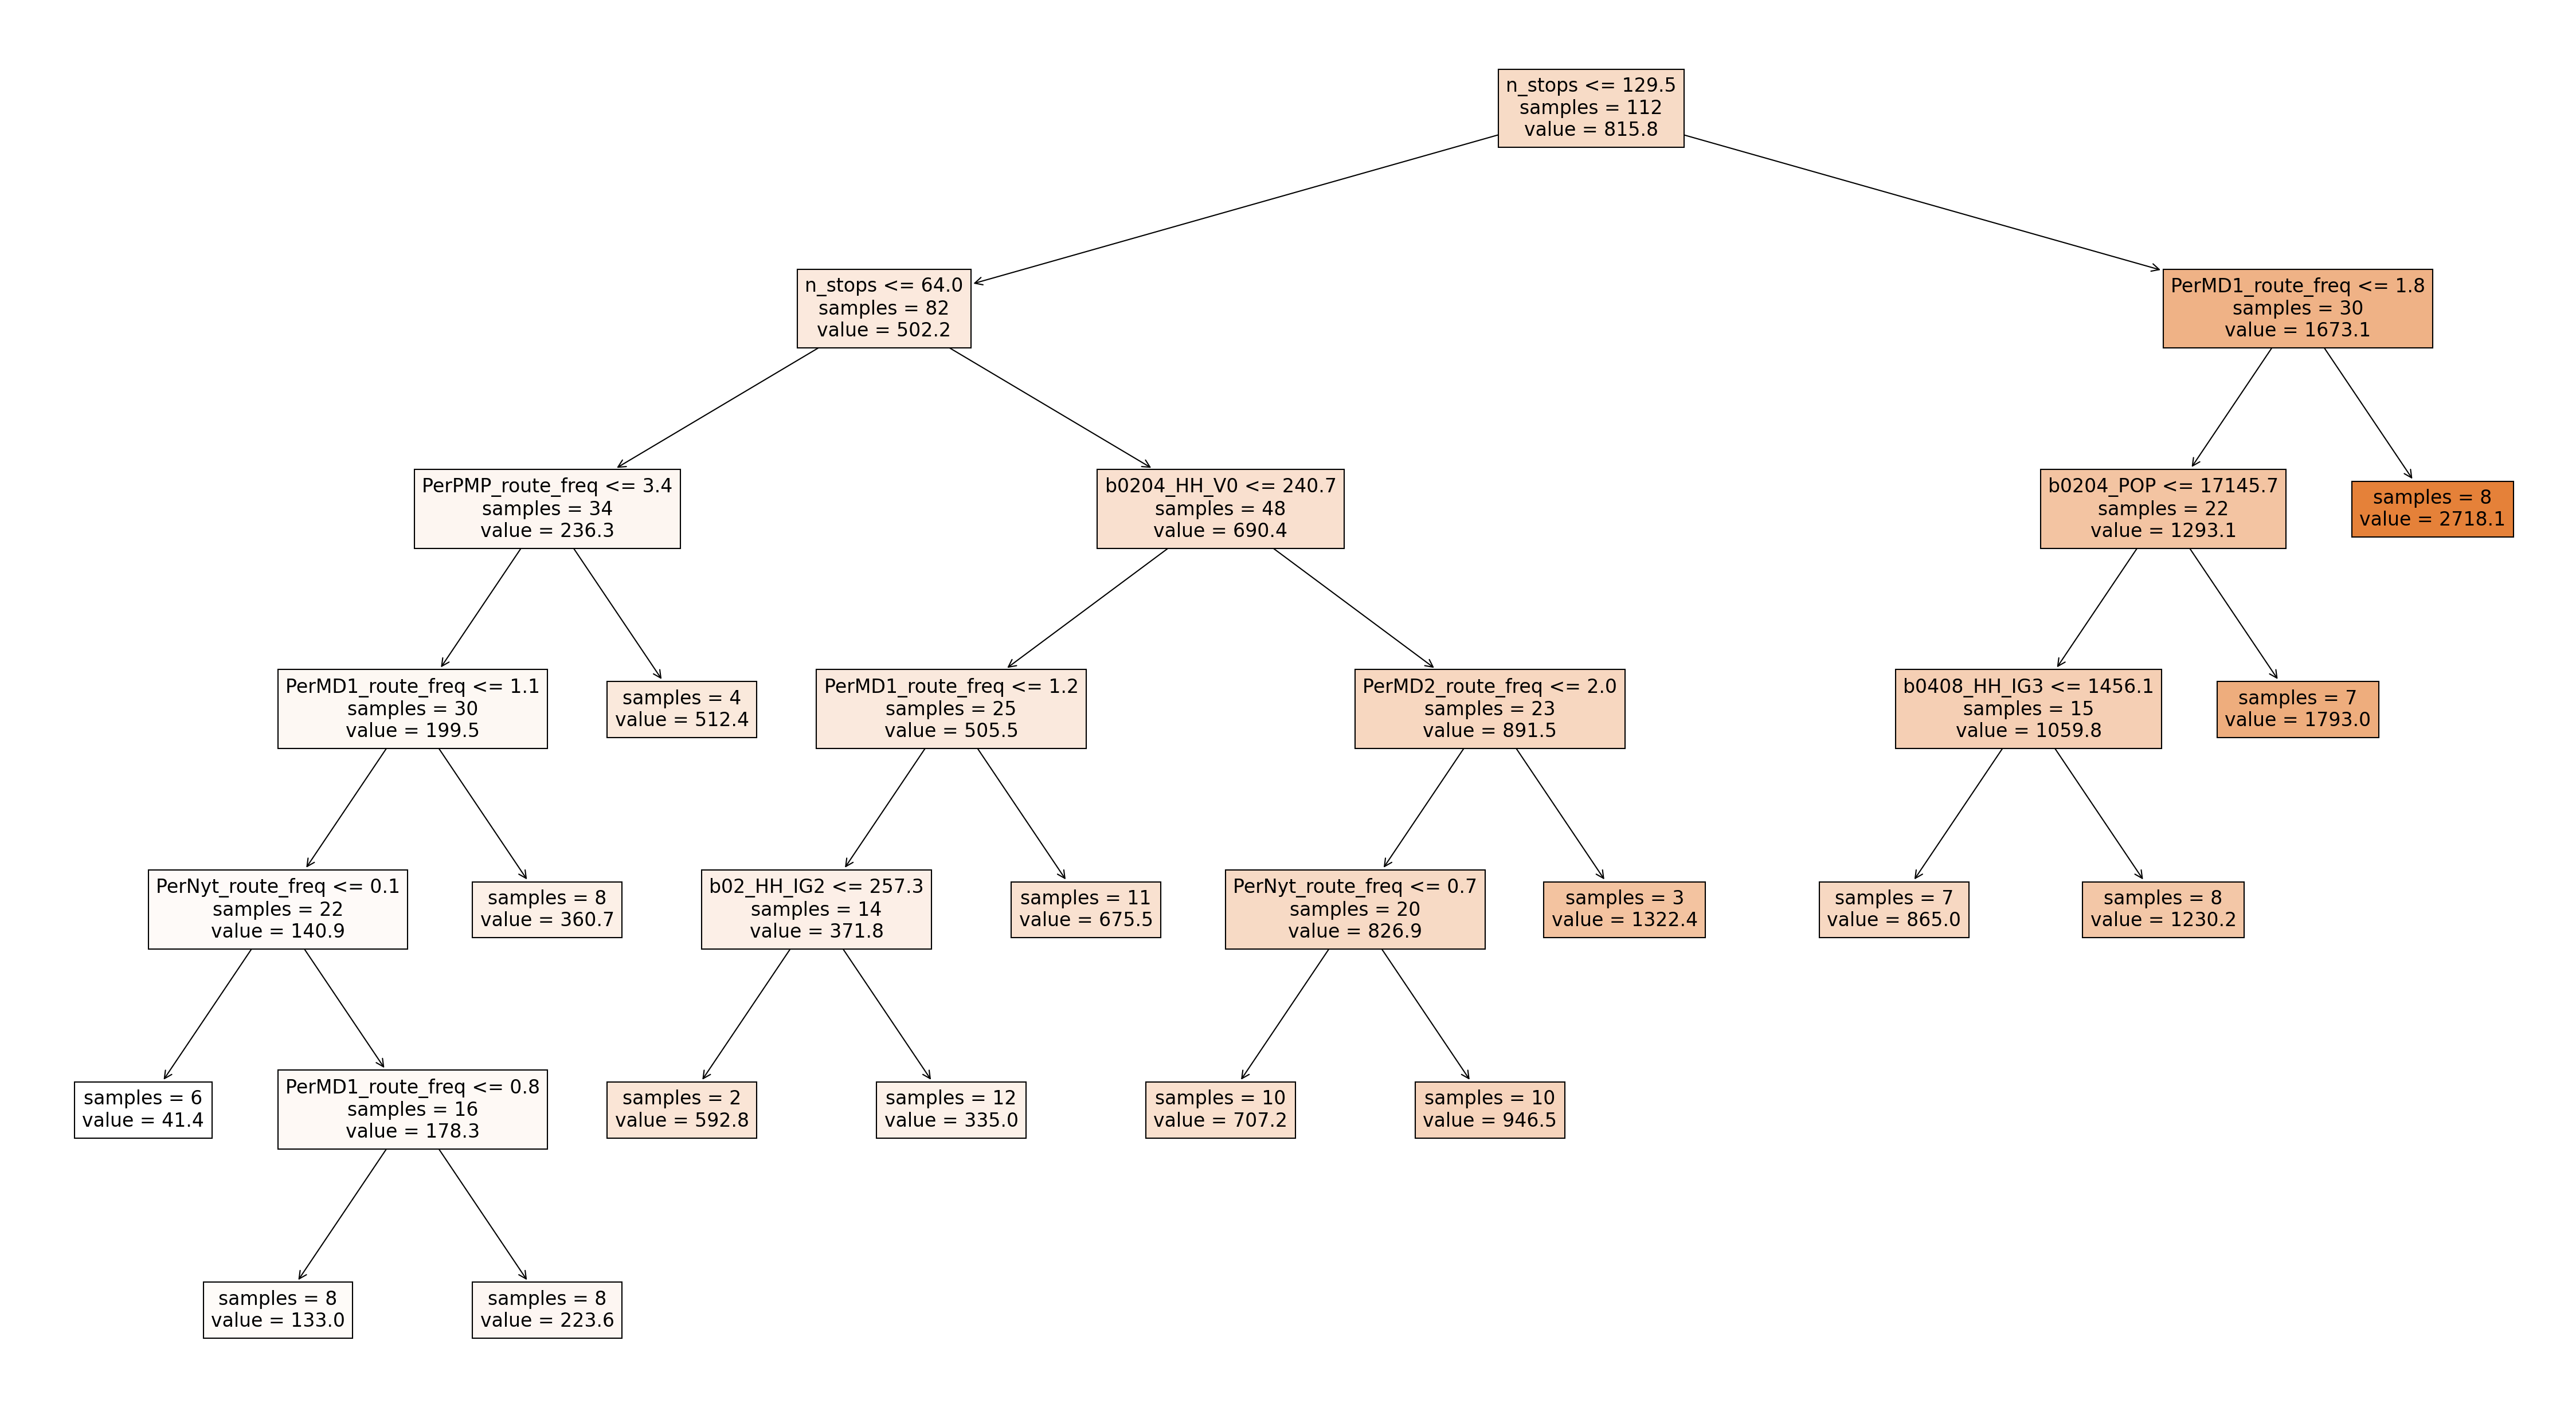

In [52]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_tree.png")
fig, ax = plt.subplots(figsize=(19.2*2, 10.8*2))
plot_tree(model["decisiontreeregressor"], feature_names = main_cols, impurity=False, precision=1, filled=True)
plt.savefig(result_loc)

Saving fitted model to file.

In [53]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### Random Forest

In [54]:
model_name = "RandomForest"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")

Fitting parameters.

In [55]:
hyper_grid = { "randomforestregressor__n_estimators": [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50, 70, 100],
               "randomforestregressor__min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
               "randomforestregressor__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10] }
model = make_pipeline(column_selector, preprocessing.StandardScaler(), ensemble.RandomForestRegressor(random_state=RANDOM_SEED))
search_model = GridSearchCV(estimator = model, param_grid = hyper_grid, cv = CV_FOLDS, verbose=1, n_jobs=-2)
search_model.fit(X_train, y_train)

Fitting 5 folds for each of 2016 candidates, totalling 10080 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done 150 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-2)]: Done 1350 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-2)]: Done 3350 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-2)]: Done 6150 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-2)]: Done 9750 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-2)]: Done 10080 out of 10080 | elapsed:  1.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['PerAMP_route_freq',
                                                                          'PerMD1_route_freq',
                                                                          'PerMD2_route_freq',
                                                                          'PerPMP_route_freq',
                                                                          'PerNyt_route_freq',
                                                                          'n_stops',
                                                                          'high_freq',
                                                                          'b02_HH_V0',
               

Best parameters based on Grid Search.

In [56]:
search_model.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__n_estimators': 20}

Fitting model.

In [57]:
model.set_params(**search_model.best_params_)
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.0312 seconds.


Evaluating goodness-of-fit.

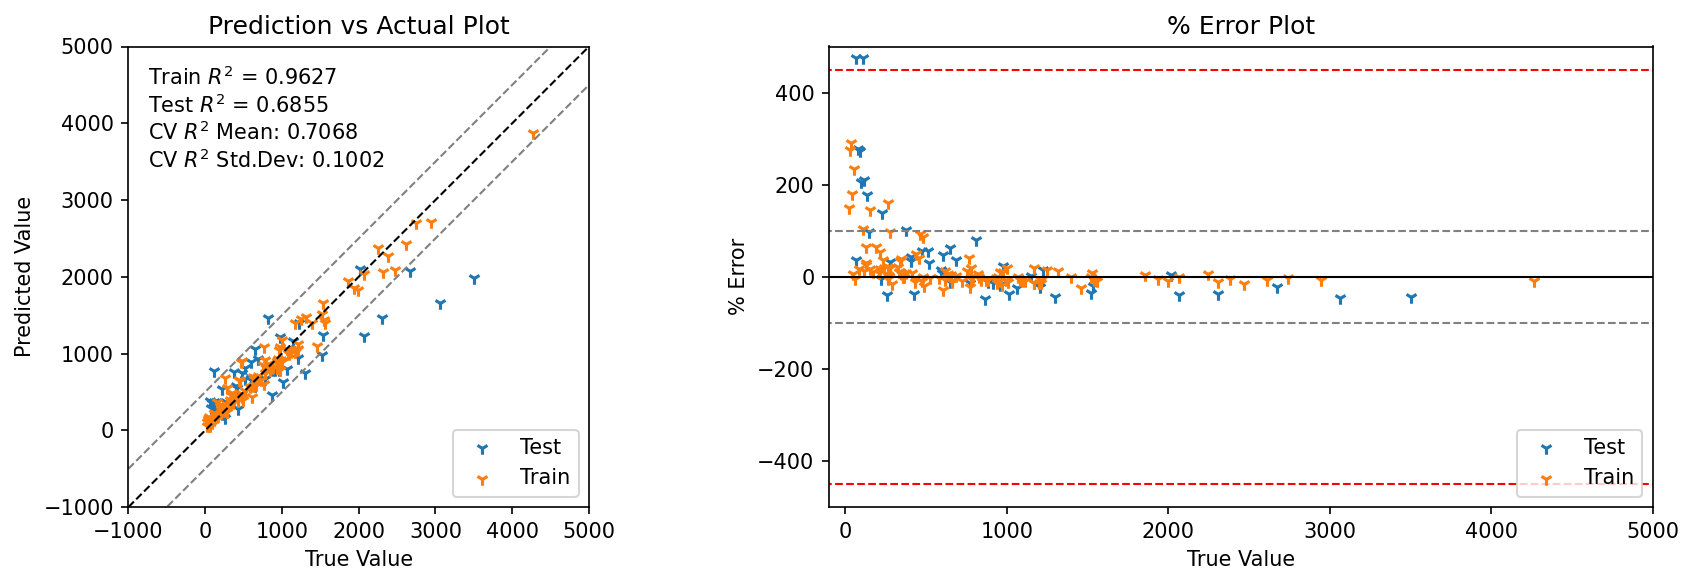

In [58]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Showing the 10 most important features.

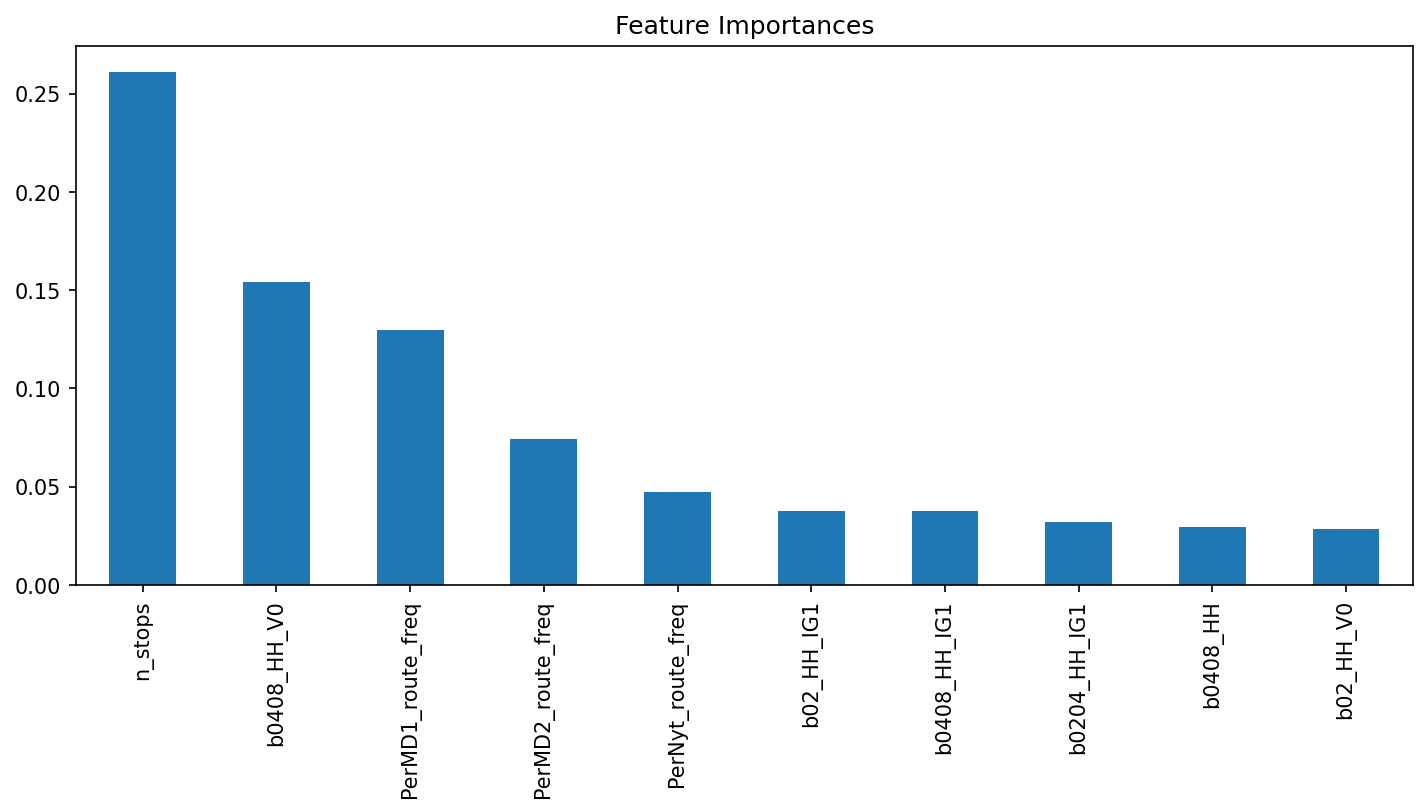

In [59]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Imp.png")
feat_imps = pd.DataFrame({"importance": model["randomforestregressor"].feature_importances_}, index=main_cols)
feat_imps[feat_imps['importance']>0].sort_values("importance", ascending=False).head(10).plot(kind = "bar", legend=None, figsize=(11.5,4.76))
plt.title("Feature Importances")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Updating prediction table.

In [60]:
output_table.loc[X.index, model_name] = model.predict(X)

Saving fitted model to file.

In [61]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### AdaBoost

In [62]:
model_name = "AdaBoost"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")

Fitting parameters.

In [63]:
hyper_grid = { "adaboostregressor__n_estimators": [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50, 70, 100],
               "adaboostregressor__learning_rate": np.arange(.1,1.01,.05) }
model = make_pipeline(column_selector, preprocessing.StandardScaler(), ensemble.AdaBoostRegressor(random_state=RANDOM_SEED))
search_model = GridSearchCV(estimator = model, param_grid = hyper_grid, cv = CV_FOLDS, verbose=1, n_jobs=-2)
search_model.fit(X_train, y_train)

Fitting 5 folds for each of 304 candidates, totalling 1520 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done 150 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 1350 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-2)]: Done 1520 out of 1520 | elapsed:   13.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['PerAMP_route_freq',
                                                                          'PerMD1_route_freq',
                                                                          'PerMD2_route_freq',
                                                                          'PerPMP_route_freq',
                                                                          'PerNyt_route_freq',
                                                                          'n_stops',
                                                                          'high_freq',
                                                                          'b02_HH_V0',
               

Best parameters based on Grid Search.

In [64]:
search_model.best_params_

{'adaboostregressor__learning_rate': 0.6500000000000001,
 'adaboostregressor__n_estimators': 20}

Fitting model.

In [65]:
model.set_params(**search_model.best_params_)
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.0379 seconds.


Evaluating goodness-of-fit.

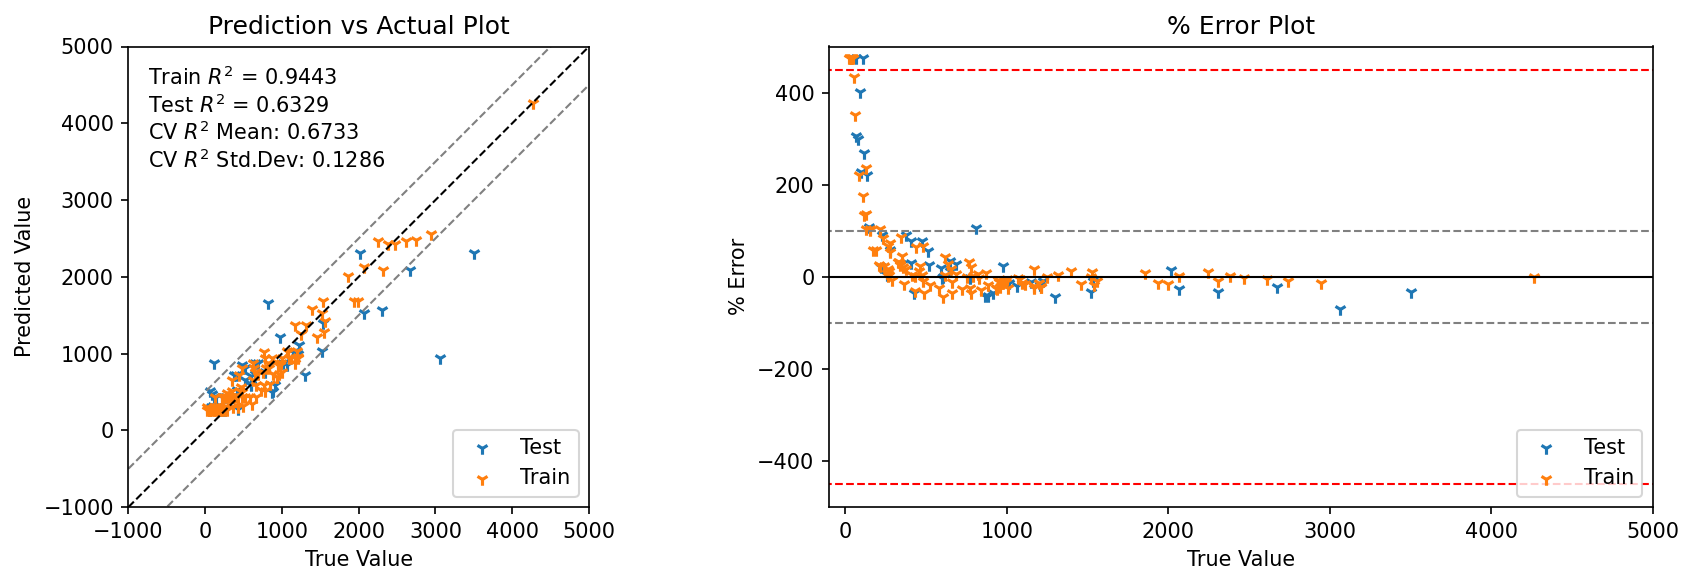

In [66]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Showing the 10 most important features.

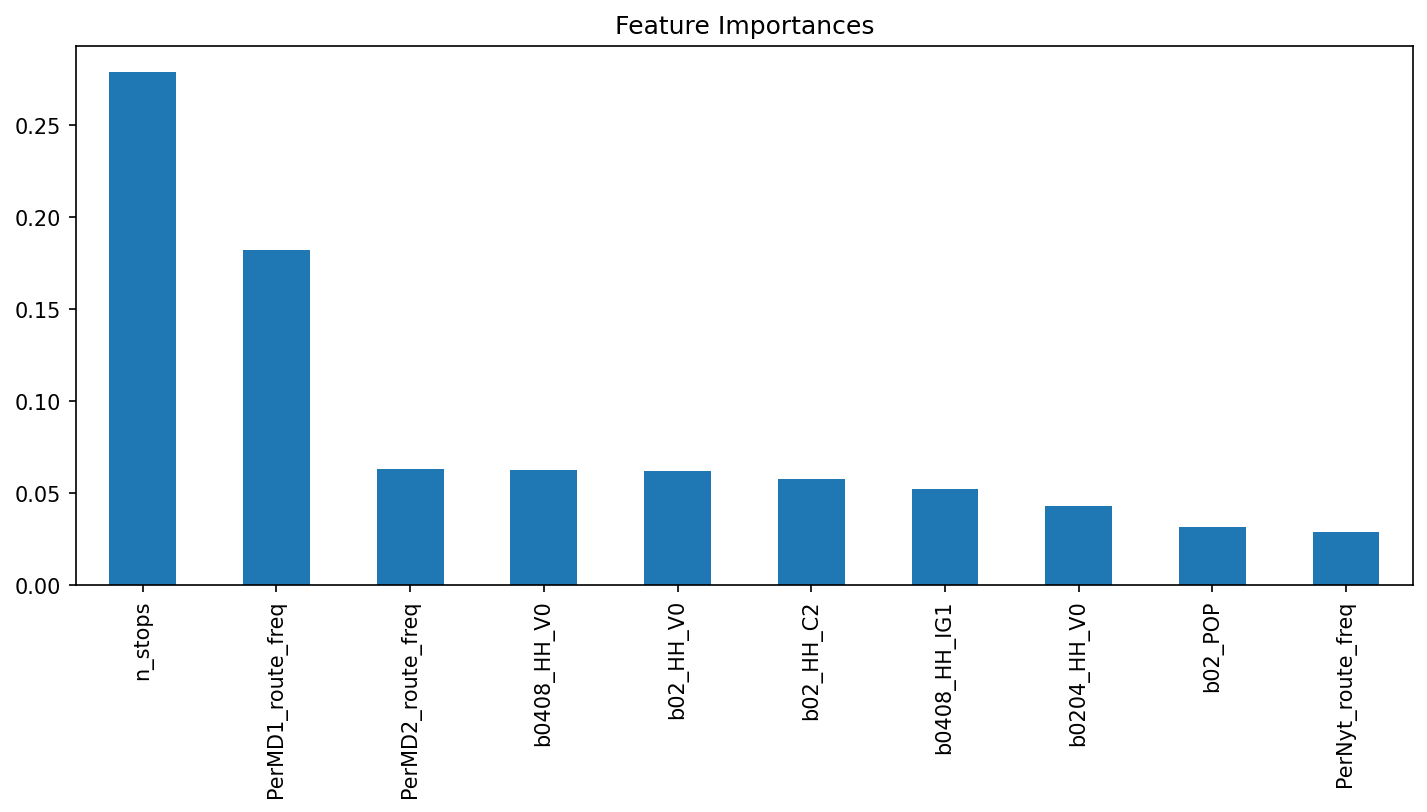

In [67]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Imp.png")
feat_imps = pd.DataFrame({"importance": model["adaboostregressor"].feature_importances_}, index=main_cols)
feat_imps[feat_imps['importance']>0].sort_values("importance", ascending=False).head(10).plot(kind = "bar", legend=None, figsize=(11.5,4.76))
plt.title("Feature Importances")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Updating prediction table.

In [68]:
output_table.loc[X.index, model_name] = model.predict(X)

Saving fitted model to file.

In [69]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

### GradientBoost

In [70]:
model_name = "GradientBoost"
column_selector = ColumnTransformer([('select', 'passthrough', main_cols)], remainder="drop")

Fitting parameters.

In [71]:
hyper_grid = { "gradientboostingregressor__n_estimators": [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50, 70, 100],
               "gradientboostingregressor__learning_rate": np.arange(.1,1.01,.05),
               "gradientboostingregressor__max_depth": [1,2,3] }
model = make_pipeline(column_selector, preprocessing.StandardScaler(), ensemble.GradientBoostingRegressor(random_state=RANDOM_SEED))
search_model = GridSearchCV(estimator = model, param_grid = hyper_grid, cv = CV_FOLDS, verbose=1, n_jobs=-2)
search_model.fit(X_train, y_train)

Fitting 5 folds for each of 912 candidates, totalling 4560 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-2)]: Done 158 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 2550 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-2)]: Done 4560 out of 4560 | elapsed:   18.7s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('select',
                                                                         'passthrough',
                                                                         ['PerAMP_route_freq',
                                                                          'PerMD1_route_freq',
                                                                          'PerMD2_route_freq',
                                                                          'PerPMP_route_freq',
                                                                          'PerNyt_route_freq',
                                                                          'n_stops',
                                                                          'high_freq',
                                                                          'b02_HH_V0',
               

Best parameters based on Grid Search.

In [72]:
search_model.best_params_

{'gradientboostingregressor__learning_rate': 0.20000000000000004,
 'gradientboostingregressor__max_depth': 2,
 'gradientboostingregressor__n_estimators': 15}

Fitting model.

In [73]:
model.set_params(**search_model.best_params_)
model_start_time = time.time()
model.fit(X_train, y_train)
print(f"Model fitted in {round(time.time() - model_start_time, 4)} seconds.")

Model fitted in 0.0279 seconds.


Evaluating goodness-of-fit.

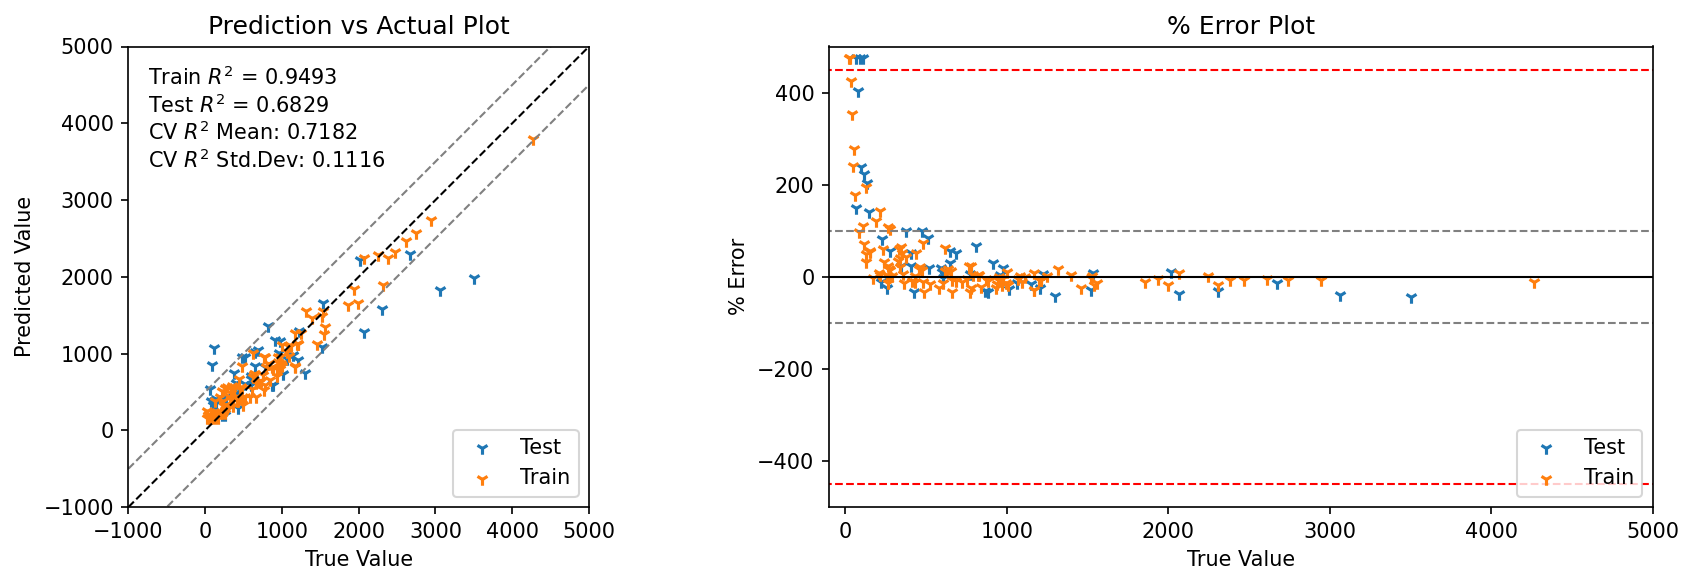

In [74]:
result_loc = os.path.join(RESULT_FOLDER, model_name + ".png")
result_summary.loc[model_name] = evaluate_gof(model, X_train, X_test, y_train, y_test, train_cv, output_location=result_loc)

Showing the 10 most important features.

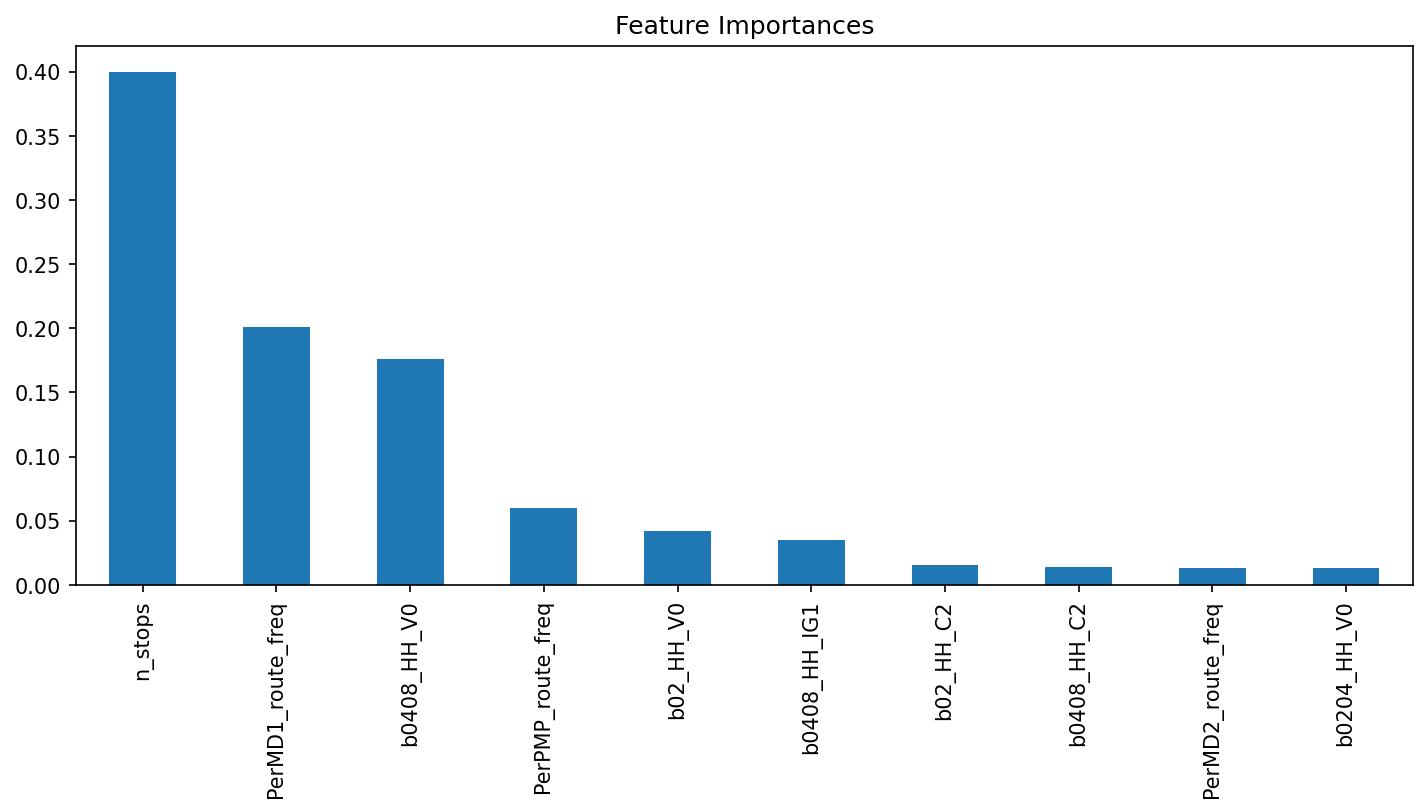

In [75]:
result_loc = os.path.join(RESULT_FOLDER, model_name + "_Imp.png")
feat_imps = pd.DataFrame({"importance": model["gradientboostingregressor"].feature_importances_}, index=main_cols)
feat_imps[feat_imps['importance']>0].sort_values("importance", ascending=False).head(10).plot(kind = "bar", legend=None, figsize=(11.5,4.76))
plt.title("Feature Importances")
fig.tight_layout()
plt.savefig(result_loc, dpi=200)

Updating prediction table.

In [76]:
output_table.loc[X.index, model_name] = model.predict(X)

Saving fitted model to file.

In [77]:
with open(os.path.join(MODELS_FOLDER, model_name + ".pickle"), "wb") as ostream:
    pickle.dump(model, ostream)

## Predictions

In [78]:
output_table[main_cols] = X[main_cols]
output_table.to_csv(os.path.join(RESULT_FOLDER, "Predictions.csv"))

In [79]:
output_table

,true_ridership,Train_Test,CV_Fold,LassoCV,RidgeCV,LassoCVSq,LassoCVSqrt,DecisionTree,RandomForest,AdaBoost,...,b0204_HH_W3,b0408_HH_W1,b0408_HH_W2,b0408_HH_W3,b02_HH_C1,b02_HH_C2,b0204_HH_C1,b0204_HH_C2,b0408_HH_C1,b0408_HH_C2
route_id,,,,,,,,,,,,,,,,,,,,,
14686,1935.546875,Train,5,2181.943024,2127.158766,2232.351950,2176.697859,1792.958754,1857.372911,1682.232691,...,334.690240,6890.142743,3773.824289,726.771039,847.801840,1301.726676,718.212331,1188.419373,1303.667547,2296.663443
14688,4268.187500,Train,4,2716.359277,3005.197746,3160.784742,2708.592450,2718.130859,3867.874687,4268.187500,...,376.914571,4811.808649,2514.519884,775.393308,569.439337,937.727139,548.719547,1050.259557,1219.909295,2296.473755
14707,1537.265625,Test,0,1373.496233,1545.162372,1184.322907,1375.737906,707.219361,1240.788619,1399.311384,...,233.283605,3194.819874,1748.414607,476.262096,629.437225,1042.316285,526.517193,979.116873,871.501507,1573.796776
14708,792.234375,Train,3,916.173877,990.276100,838.564247,921.442678,946.537500,814.222235,807.039627,...,164.340612,2404.054193,1270.064599,329.338481,489.008644,664.929955,257.166699,463.090998,564.100345,1000.823732
14689,1226.328125,Test,0,1399.008176,1441.534279,1367.920274,1402.642167,865.024554,1397.543080,1113.349757,...,116.770948,2172.674969,960.380397,175.186303,430.365400,625.625492,281.264713,465.856647,430.934546,742.147985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4545,114.913043,Train,5,65.273239,153.890632,63.249384,72.433948,133.006126,128.927298,268.189726,...,105.914168,2280.339943,1308.649196,293.344033,263.610618,394.260902,371.839615,555.092979,870.494375,1328.778270
4546,52.173913,Train,1,164.251883,146.274904,278.670907,168.953193,41.351676,174.163307,278.669359,...,308.284381,3666.309650,1932.206005,510.741189,655.116362,970.367381,827.623691,1232.384237,1324.187943,1973.825578
4516,260.391304,Test,0,138.733110,93.516868,177.646806,148.396247,223.574219,158.355353,268.189726,...,51.401471,1233.167463,639.179495,59.947317,67.100153,109.691791,79.299961,128.251642,129.957434,203.154115


Summary of measures of fit.

In [80]:
result_summary.to_csv(os.path.join(RESULT_FOLDER, "fit_summary.csv"))
result_summary

,train_r2,test_r2,cv_r2,cv_r2_sd
LassoCV,0.799380,0.734807,0.717558,0.034885
RidgeCV,0.833045,0.746535,0.698557,0.048879
LassoCVSq,0.819337,0.762826,0.687191,0.055777
LassoCVSqrt,0.799323,0.734921,0.716835,0.035530
DecisionTree,0.892042,0.646073,0.496614,0.106551
RandomForest,0.962746,0.685523,0.706771,0.100200
AdaBoost,0.944304,0.632881,0.673332,0.128562
GradientBoost,0.949318,0.682939,0.718158,0.111596
